### Example 6.5: Windy Gridworld

<p style="text-align: justify;">
Shown inset below is a standard gridworld, with start and goal states, but with one difference: there is a crosswind running upward through the middle of the grid. The actions are the standard four—<code>up</code>, <code>down</code>, <code>right</code>, and <code>left</code>—but in the middle region the resultant next states are shifted upward by a “wind”, the strength of which varies from column to column. The strength of the wind is given below each column, in number of cells shifted upward. For example, if you are one cell to the right of the goal, then the action <code>left</code> takes you to the cell just above the goal. This is an undiscounted episodic task, with constant rewards of $-1$ until the goal state is reached.
</p>

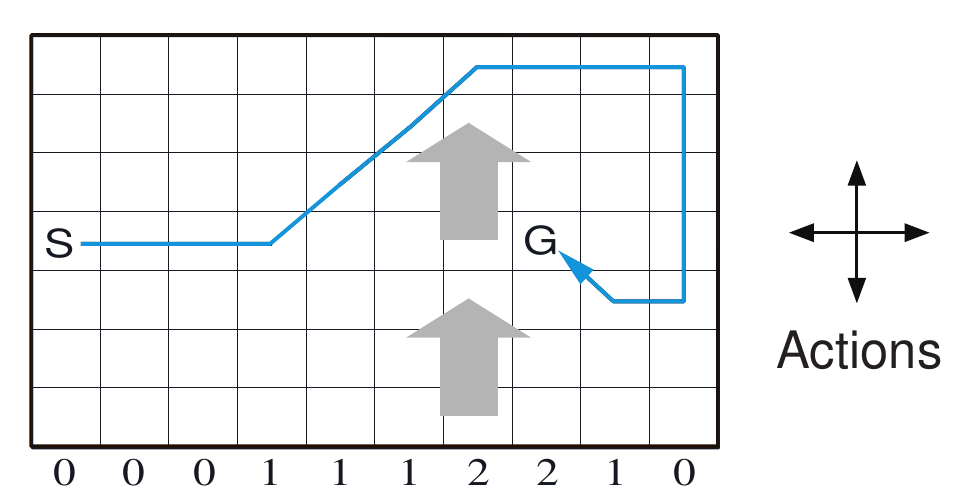

In [1]:
from IPython.display import Image
Image("ch06_ex09_ex10/gridworld.png")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn

from pprint import pprint
from tqdm import tqdm

%matplotlib inline

### Settings

In [3]:
alpha   = 0.5  # "learning rate"
epsilon = 0.1  # e-greedy probability
gamma   = 1.0  # discount factor

n_episodes = 500000  # total number of episodes

movement_types = ['basic', 'king', 'king_0']
wind_types = ['no', 'det', 'stoch']

### Functions

In [30]:
def create_path(world):
    
    all_states = world['all_states']
    policy     = world['P']
    
    wind_cols   = world['wind_cols']
    wind_change = world['wind_change']
    wind_type   = world['wind_type']
    
    v_len = world['v_len']
    h_len = world['h_len']
    
    start_states = world['start_states']
    goal_states  = world['goal_states']
    
    v_len = world['v_len']
    h_len = world['h_len']
            
    past_states = set()
    state = random.choice(list(start_states))
    
    step = 0
    
    while True:
        
        if state not in all_states:
            print('\nERROR: Out of bounds!')
            break
            
        if state in past_states and wind_type != 'stoch':
            print('\nFAILURE: Goal states cannot be reached!')
            break
            
        if state in goal_states:
            print(f'{step:>3d} | S: {state}')
            print(f'\nSUCCESS: Goal state {state} has been reached in {step} steps!')
            break
            
        action = policy[state]
        
        # Generate wind
        wind = wind_cols[state[1]]  # wind_type == 'det'

        if wind_type == 'no':
            wind = 0

        if wind_type == 'stoch':
            wind += random.choice(wind_change)

        print(f'{step:>3d} | S: {state} | Wind: {wind} | A: {action}')
        
        past_states.add(state)
        next_v = max(0, min(v_len-1, state[0] + action[0] + wind))
        next_h = max(0, min(h_len-1, state[1] + action[1]))
        state = (next_v, next_h)
        
        step += 1
        
    return

In [5]:
def get_best_action(q):
    best_value = -np.inf
    best_action = None
    
    for action in q.keys():
        if best_value < q[action]:
            best_value = q[action]
            best_action = action
            
    return best_action

In [6]:
def get_neighborhood(states):
    return{
        (state[0] + v_change, state[1] + h_change)
        for state in states
        for v_change in [-1, 0, 1]
        for h_change in [-1, 0, 1]
    }

In [7]:
def print_policy(mp):
    for state in sorted(mp['all_states']):
        print(state, mp['P'][state], get_best_action(mp['Q'][state]))
        pprint(mp['Q'][state])
        print()
    return

### Algorithms

In [10]:
def initialize(movement_type):
    """
    movement_type = {
        'basic': 4 lateral directions
        'king': 8 directions (4 lateral + 4 diagonal)
        'king_0': 8 directions + no movement
    }
    """
    
    if movement_type not in movement_types:
        print(f'Movement type {movement_type} not known!')
        return None
    
    v_len, h_len = 7, 10
    
    # Actions
    all_actions = {
        ( 1,  0),  # up
        (-1,  0),  # down
        ( 0,  1),  # right
        ( 0, -1)   # left
    }
    
    if movement_type in {'king', 'king_0'}:
        all_actions = all_actions.union({
            ( 1, -1),  # up-left
            ( 1,  1),  # up-right
            (-1, -1),  # down-left
            (-1,  1)   # down-right
        })
        
        if movement_type == 'king_0':
            all_actions.add(
                (0, 0)  # no movement
            )
    
    # States
    all_states = {
        (v, h)
        for v in range(v_len)
        for h in range(h_len)
    }
    
    start_states = {
        (3, 0)
    }
    
    goal_states  = {
        (3, 7)
    }
    
    # Wind
    wind_cols = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
    wind_change = [-1, 0, 1]
    
    # Variables
    P = dict()  # policy
    Q = dict()  # state-action values
    R = dict()  # rewards
    
    for state in all_states:
        
        # Initialize dicts of Q
        Q.setdefault(state, dict())
        
        # Initialize rewards
        R[state] = -1
        
        for action in all_actions:
            
            # Initialize state-action values
            Q[state][action] = np.random.normal()
    
        # Initialize policies
        P[state] = get_best_action(Q[state])
        
    return {
        'all_actions': all_actions,
        'all_states': all_states,
        'start_states': start_states,
        'goal_states': goal_states,
        'wind_cols': wind_cols,
        'wind_change': wind_change,
        'P': P,
        'Q': Q,
        'R': R,
        'v_len': v_len,
        'h_len': h_len,
        'n_episode': 0,
        'total_steps': list()
    }

In [11]:
def iterate(world, wind_type='det',
            alpha=0.5, epsilon=0.1, gamma=1.0, n_episodes=1000):
    """
    wind_type = {
        'no': no wind at all
        'det': deterministic (as in the original problem)
        'stoch': stochastic (as in Exercise )
    }
    """
    
    if wind_type not in wind_types:
        print(f'Wind type {wind_type} not known!')
        return world
    
    # Load constants
    all_actions = world['all_actions']
    all_states = world['all_states']
    
    start_states = world['start_states']
    goal_states = world['goal_states']
    
    v_len = world['v_len']
    h_len = world['h_len']
    
    wind_cols = world['wind_cols']
    wind_change = world['wind_change']
    
    # Load variables
    P = world['P']
    Q = world['Q']
    R = world['R']
    
    n_episode = world['n_episode']
    total_steps = world['total_steps']
    
    for state in goal_states:
        for action in all_actions:
            Q[state][action] = 0
    
#     goal_neighbors = get_neighborhood(goal_states)
#     print(f'Goal neighbor states:\n{goal_neighbors}\n')
    
    # Iterate
    for i in tqdm(range(n_episodes)):

        # Initialize start state
        state = random.choice(list(start_states))  # s[0]

        # Choose an action from this state using policy derived from Q (e-greedy)
        action = P[state]
        if np.random.uniform() < epsilon:
            action = random.choice(list(all_actions))

        # Initialize number of steps
        n_steps = 1
        
        while state not in goal_states:
            
#             if state in goal_neighbors:
#                 print(f'Episode {i+1 + n_episode:>7d} | {n_steps:>7d} steps:', state)

            # Generate wind
            wind = wind_cols[state[1]]  # wind_type == 'det'
        
            if wind_type == 'no':
                wind = 0
            
            if wind_type == 'stoch':
                wind += random.choice(wind_change)

            # Make that action
            next_v = max(0, min(v_len-1, state[0] + action[0] + wind))
            next_h = max(0, min(h_len-1, state[1] + action[1]))
            next_state = (next_v, next_h)
        
            # Choose an action from the new state (e-greedy)
            next_action = P[next_state]
            if np.random.uniform() < epsilon:
                next_action = random.choice(list(all_actions))

            # Update state-action values
            Q[state][action] += alpha * (R[next_state] + 
                                         gamma * Q[next_state][next_action] - 
                                         Q[state][action])
            
            # Update policy
            P[state] = get_best_action(Q[state])
            
            # Move towards new state
            state = next_state
            action = next_action
            
            # Update step counter
            n_steps += 1
            
#         print(f'Episode {i+1 + n_episode:>9d} | {n_steps:>9d} steps:', state)
        total_steps.append(n_steps)

    return {
        'all_actions': all_actions,
        'all_states': all_states,
        'start_states': start_states,
        'goal_states': goal_states,
        'wind_cols': wind_cols,
        'wind_change': wind_change,
        'P': P,
        'Q': Q,
        'R': R,
        'v_len': v_len,
        'h_len': h_len,
        'n_episode': n_episode + n_episodes,
        'total_steps': total_steps,
        'wind_type': wind_type
    }

<hr style="height: 1px;">

#### Basic movements

In [12]:
basic_world = initialize(movement_type='basic')

In [13]:
basic_world = iterate(basic_world, n_episodes=n_episodes,
                      alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|██████████| 500000/500000 [00:41<00:00, 12042.65it/s]


In [31]:
create_path(basic_world)

  0 | S: (3, 0) | Wind: 0 | A: (0, 1)
  1 | S: (3, 1) | Wind: 0 | A: (0, 1)
  2 | S: (3, 2) | Wind: 0 | A: (1, 0)
  3 | S: (4, 2) | Wind: 0 | A: (0, 1)
  4 | S: (4, 3) | Wind: 1 | A: (0, 1)
  5 | S: (5, 4) | Wind: 1 | A: (0, 1)
  6 | S: (6, 5) | Wind: 1 | A: (0, 1)
  7 | S: (6, 6) | Wind: 2 | A: (0, 1)
  8 | S: (6, 7) | Wind: 2 | A: (0, 1)
  9 | S: (6, 8) | Wind: 1 | A: (0, 1)
 10 | S: (6, 9) | Wind: 0 | A: (-1, 0)
 11 | S: (5, 9) | Wind: 0 | A: (-1, 0)
 12 | S: (4, 9) | Wind: 0 | A: (-1, 0)
 13 | S: (3, 9) | Wind: 0 | A: (-1, 0)
 14 | S: (2, 9) | Wind: 0 | A: (0, -1)
 15 | S: (2, 8) | Wind: 1 | A: (0, -1)
 16 | S: (3, 7)

SUCCESS: Goal state (3, 7) has been reached in 16 steps!


<hr style="height: 1px;">

# Exercise 6.9

#### Windy Gridworld with King's Moves

<p style="text-align: justify;">
Re-solve the windy gridworld assuming eight possible actions, including the diagonal moves, rather than the usual four. How much better can you do with the extra actions?
</p>

In [15]:
king_world = initialize(movement_type='king')

In [16]:
king_world = iterate(king_world, n_episodes=n_episodes,
                     alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|██████████| 500000/500000 [00:26<00:00, 18910.55it/s]


In [32]:
create_path(king_world)

  0 | S: (3, 0) | Wind: 0 | A: (-1, 1)
  1 | S: (2, 1) | Wind: 0 | A: (-1, 1)
  2 | S: (1, 2) | Wind: 0 | A: (-1, 1)
  3 | S: (0, 3) | Wind: 1 | A: (-1, 1)
  4 | S: (0, 4) | Wind: 1 | A: (-1, 1)
  5 | S: (0, 5) | Wind: 1 | A: (-1, 1)
  6 | S: (0, 6) | Wind: 2 | A: (1, 1)
  7 | S: (3, 7)

SUCCESS: Goal state (3, 7) has been reached in 7 steps!


<hr style="height: 1px;">

#### King movements + no movement

<p style="text-align: justify;">
Can you do even better by including a ninth action that causes no movement at all other than that caused by the wind?
</p>

In [18]:
king_0_world = initialize(movement_type='king_0')

In [19]:
king_0_world = iterate(king_0_world, n_episodes=n_episodes,
                       alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|██████████| 500000/500000 [00:26<00:00, 18741.88it/s]


In [33]:
create_path(king_0_world)

  0 | S: (3, 0) | Wind: 0 | A: (-1, 1)
  1 | S: (2, 1) | Wind: 0 | A: (-1, 1)
  2 | S: (1, 2) | Wind: 0 | A: (-1, 1)
  3 | S: (0, 3) | Wind: 1 | A: (-1, 1)
  4 | S: (0, 4) | Wind: 1 | A: (0, 1)
  5 | S: (1, 5) | Wind: 1 | A: (-1, 1)
  6 | S: (1, 6) | Wind: 2 | A: (0, 1)
  7 | S: (3, 7)

SUCCESS: Goal state (3, 7) has been reached in 7 steps!


# Exercise 6.10

<p style="text-align: justify;">
Re-solve the windy gridworld task with King’s moves, assuming that the effect of the wind, if there is any, is stochastic, sometimes varying by $1$ from the mean values given for each column. That is, a third of the time you move exactly according to these values, as in the previous exercise, but also a third of the time you move one cell above that, and another third of the time you move one cell below that. For example, if you are one cell to the right of the goal and you move <code>left</code>, then one-third of the time you move one cell above the goal, one-third of the time you move two cells above the goal, and one-third of the time you move to the goal.
</p>

#### Basic movements

In [21]:
stoch_basic_world = initialize(movement_type='basic')

In [22]:
stoch_basic_world = iterate(stoch_basic_world, n_episodes=n_episodes,
                            wind_type='stoch',  # stochastic
                            alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|██████████| 500000/500000 [02:37<00:00, 3168.73it/s]


In [35]:
create_path(stoch_basic_world)

  0 | S: (3, 0) | Wind: -1 | A: (-1, 0)
  1 | S: (1, 0) | Wind: 1 | A: (0, 1)
  2 | S: (2, 1) | Wind: 0 | A: (-1, 0)
  3 | S: (1, 1) | Wind: -1 | A: (0, 1)
  4 | S: (0, 2) | Wind: -1 | A: (0, 1)
  5 | S: (0, 3) | Wind: 2 | A: (0, 1)
  6 | S: (2, 4) | Wind: 0 | A: (0, 1)
  7 | S: (2, 5) | Wind: 0 | A: (0, 1)
  8 | S: (2, 6) | Wind: 2 | A: (0, 1)
  9 | S: (4, 7) | Wind: 2 | A: (0, 1)
 10 | S: (6, 8) | Wind: 1 | A: (0, 1)
 11 | S: (6, 9) | Wind: 1 | A: (-1, 0)
 12 | S: (6, 9) | Wind: -1 | A: (-1, 0)
 13 | S: (4, 9) | Wind: 0 | A: (-1, 0)
 14 | S: (3, 9) | Wind: 0 | A: (-1, 0)
 15 | S: (2, 9) | Wind: 1 | A: (-1, 0)
 16 | S: (2, 9) | Wind: 1 | A: (-1, 0)
 17 | S: (2, 9) | Wind: 0 | A: (-1, 0)
 18 | S: (1, 9) | Wind: -1 | A: (-1, 0)
 19 | S: (0, 9) | Wind: 0 | A: (0, -1)
 20 | S: (0, 8) | Wind: 0 | A: (0, -1)
 21 | S: (0, 7) | Wind: 2 | A: (-1, 0)
 22 | S: (1, 7) | Wind: 1 | A: (-1, 0)
 23 | S: (1, 7) | Wind: 2 | A: (-1, 0)
 24 | S: (2, 7) | Wind: 1 | A: (-1, 0)
 25 | S: (2, 7) | Wind: 3 | A

#### King movements

In [24]:
stoch_king_world = initialize(movement_type='king')

In [25]:
stoch_king_world = iterate(stoch_king_world, n_episodes=n_episodes,
                           wind_type='stoch',  # stochastic
                           alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|██████████| 500000/500000 [01:52<00:00, 4453.72it/s]


In [36]:
create_path(stoch_king_world)

  0 | S: (3, 0) | Wind: -1 | A: (-1, 1)
  1 | S: (1, 1) | Wind: -1 | A: (-1, 1)
  2 | S: (0, 2) | Wind: 1 | A: (-1, 1)
  3 | S: (0, 3) | Wind: 1 | A: (0, 1)
  4 | S: (1, 4) | Wind: 0 | A: (-1, 1)
  5 | S: (0, 5) | Wind: 1 | A: (-1, 1)
  6 | S: (0, 6) | Wind: 1 | A: (0, 1)
  7 | S: (1, 7) | Wind: 1 | A: (1, 0)
  8 | S: (3, 7)

SUCCESS: Goal state (3, 7) has been reached in 8 steps!


#### King movements + no movement

In [27]:
stoch_king_0_world = initialize(movement_type='king_0')

In [28]:
stoch_king_0_world = iterate(stoch_king_0_world, n_episodes=n_episodes,
                             wind_type='stoch',  # stochastic
                             alpha=alpha, epsilon=epsilon, gamma=gamma)

100%|██████████| 500000/500000 [01:59<00:00, 4190.56it/s]


In [40]:
create_path(stoch_king_0_world)

  0 | S: (3, 0) | Wind: 0 | A: (-1, 1)
  1 | S: (2, 1) | Wind: -1 | A: (0, 1)
  2 | S: (1, 2) | Wind: 1 | A: (1, 0)
  3 | S: (3, 2) | Wind: 0 | A: (-1, 0)
  4 | S: (2, 2) | Wind: -1 | A: (-1, 1)
  5 | S: (0, 3) | Wind: 1 | A: (-1, 1)
  6 | S: (0, 4) | Wind: 0 | A: (-1, 1)
  7 | S: (0, 5) | Wind: 2 | A: (-1, 1)
  8 | S: (1, 6) | Wind: 2 | A: (1, 1)
  9 | S: (4, 7) | Wind: 3 | A: (0, 1)
 10 | S: (6, 8) | Wind: 1 | A: (-1, 1)
 11 | S: (6, 9) | Wind: 1 | A: (-1, 0)
 12 | S: (6, 9) | Wind: 0 | A: (-1, 0)
 13 | S: (5, 9) | Wind: 0 | A: (-1, 1)
 14 | S: (4, 9) | Wind: -1 | A: (-1, 1)
 15 | S: (2, 9) | Wind: 0 | A: (-1, 1)
 16 | S: (1, 9) | Wind: 1 | A: (-1, 1)
 17 | S: (1, 9) | Wind: 1 | A: (-1, 1)
 18 | S: (1, 9) | Wind: 1 | A: (-1, 1)
 19 | S: (1, 9) | Wind: -1 | A: (-1, 1)
 20 | S: (0, 9) | Wind: 1 | A: (-1, -1)
 21 | S: (0, 8) | Wind: 2 | A: (1, -1)
 22 | S: (3, 7)

SUCCESS: Goal state (3, 7) has been reached in 22 steps!
